# Unsupervised Learning Trading Strategies

On previous notebooks, I have shared some supervised approach on doing Algorithmic Trading, now I will try to explore more how to use unsupervised learning on trading, especially using k-means clustering. This notebook is inspired by one of the videos of freeCodeCamp.org (`https://youtu.be/9Y3yaoi9rUQ?si=fGIO-ZAIfmlKX6Ni`) and I will do some modifications through all of the processes there. I hope you enjoy the notebook and please let me know if you ahve any suggestions regarding the code.

### Setup

I will code all of the programs here using Python, so make sure that you have Python Notebook IDE inside your local machine, it can be VS Code or Jupyter Notebook. Then, maybe some of you are using VS Code, I recommend you to download some important packages in Python first, which are

1. pandas
2. numpy
3. matplotlib
4. statsmodels
5. pandas_datareader
6. datetime
7. yfinance
8. scikit-learn
9. PyPortfolioOpt

You can easily type either in your venv or directly into your local pip, with `pip install -r requirements.txt`

After that we can go through the process taht we want. Take

### *1. Download/Load SP500 stocks prices data*

In [6]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [7]:
# reading SP500 company data from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# We will use dash as the substitution for dot in the symbols to avoid any errors on yfinance reading later
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
symbols_list

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'APO',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BAX',
 'BDX',
 'BRK-B',
 'BBY',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF-B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 

In [8]:
end_date = '2024-12-12'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)
start_date

Timestamp('2016-12-12 00:00:00')

In [9]:
df = yf.download(tickers = symbols_list, start=start_date, end=end_date).stack()

[*********************100%%**********************]  503 of 503 completed


In [10]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-12 A        43.369217   46.139999   46.750000   46.110001   46.180000   
           AAPL     26.232111   28.325001   28.750000   28.122499   28.322500   
           ABBV     44.002853   62.040001   62.450001   61.509998   61.529999   
           ABT      33.917850   39.200001   39.509998   39.060001   39.200001   
           ACGL     29.303333   29.303333   29.363333   28.660000   28.900000   
...                       ...         ...         ...         ...         ...   
2024-12-11 XYL     123.379997  123.379997  129.369995  123.080002  129.369995   
           YUM     138.539993  138.539993  139.059998  137.789993  138.520004   
           ZBH     106.910004  106.910004  108.940002  106.750000  108.580002   
           ZBRA    404.170013  404.170013  409.869995  402.540009  404.250000   
           ZTS     177.169998  177.169998  178.380005  175.809998  176.259995   

Price                   volume  
date       ticker               
2016-12-12 A         1851500.0  
           AAPL    105497600.0  
           ABBV      5984500.0  
           ABT       7771700.0  
           ACGL      1787400.0  
...                        ...  
2024-12-11 XYL       2273800.0  
           YUM       1357400.0  
           ZBH       1575000.0  
           ZBRA       328500.0  
           ZTS       1782400.0  

[992455 rows x 6 columns]

### *2. Calculate features and technical indicators dor each stock.*

Here, we are going to calculate some features and technical indicators, such as
1. Garman-Klass Volatility
2. Bollinger Bands
3. MACD
4. Dollar Volume
5. RSI
6. ATR

Garman-Klass Volatility is a refined measure of market volatility derived from high, low, open, and close prices. It improves on Parkinson's Volatility by incorporating open and close prices, providing a more accurate view of price fluctuations. Additionally, it adjusts for the fact that markets are not open 24/7, addressing overnight gaps for better accuracy.

This measure is particularly suitable for intraday volatility, which is crucial in daily trading. It captures short-term market dynamics, making it valuable for identifying patterns in our unsupervised learning strategy. By analyzing volatility trends, we can detect clusters or anomalies, enhancing the effectiveness of our trading insights.

The formula is:

$$
\text{Garman-Klass Volatility} = \frac{(\ln(\text{high})-\ln(\text{low}))^2}{2}-(2\ln(2)-1)(\ln(\text{Adj Close})-\ln(\text{open}))^2
$$

In [14]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-12 A        43.369217   46.139999   46.750000   46.110001   46.180000   
           AAPL     26.232111   28.325001   28.750000   28.122499   28.322500   
           ABBV     44.002853   62.040001   62.450001   61.509998   61.529999   
           ABT      33.917850   39.200001   39.509998   39.060001   39.200001   
           ACGL     29.303333   29.303333   29.363333   28.660000   28.900000   
...                       ...         ...         ...         ...         ...   
2024-12-11 XYL     123.379997  123.379997  129.369995  123.080002  129.369995   
           YUM     138.539993  138.539993  139.059998  137.789993  138.520004   
           ZBH     106.910004  106.910004  108.940002  106.750000  108.580002   
           ZBRA    404.170013  404.170013  409.869995  402.540009  404.250000   
           ZTS     177.169998  177.169998  178.380005  175.809998  176.259995   

Price                   volume  garman_klass_vol  
date       ticker                                 
2016-12-12 A         1851500.0         -0.001428  
           AAPL    105497600.0         -0.002027  
           ABBV      5984500.0         -0.043307  
           ABT       7771700.0         -0.008027  
           ACGL      1787400.0          0.000220  
...                        ...               ...  
2024-12-11 XYL       2273800.0          0.000374  
           YUM       1357400.0          0.000042  
           ZBH       1575000.0          0.000113  
           ZBRA       328500.0          0.000163  
           ZTS       1782400.0          0.000095  

[992455 rows x 7 columns]

Bollinger bands are a volatility indicator consisting of a moving average and two standard deviation bands. They also provide information on price dispersion and can help identify periods of high or low volatility. Here, we will use the lower, middle, and high bands to compute and determine the price movements, which can be useful in clustering price behaviors.

In [16]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-12 A        43.369217   46.139999   46.750000   46.110001   46.180000   
           AAPL     26.232111   28.325001   28.750000   28.122499   28.322500   
           ABBV     44.002853   62.040001   62.450001   61.509998   61.529999   
           ABT      33.917850   39.200001   39.509998   39.060001   39.200001   
           ACGL     29.303333   29.303333   29.363333   28.660000   28.900000   
...                       ...         ...         ...         ...         ...   
2024-12-11 XYL     123.379997  123.379997  129.369995  123.080002  129.369995   
           YUM     138.539993  138.539993  139.059998  137.789993  138.520004   
           ZBH     106.910004  106.910004  108.940002  106.750000  108.580002   
           ZBRA    404.170013  404.170013  409.869995  402.540009  404.250000   
           ZTS     177.169998  177.169998  178.380005  175.809998  176.259995   

Price                   volume  garman_klass_vol    bb_low    bb_mid   bb_high  
date       ticker                                                               
2016-12-12 A         1851500.0         -0.001428       NaN       NaN       NaN  
           AAPL    105497600.0         -0.002027       NaN       NaN       NaN  
           ABBV      5984500.0         -0.043307       NaN       NaN       NaN  
           ABT       7771700.0         -0.008027       NaN       NaN       NaN  
           ACGL      1787400.0          0.000220       NaN       NaN       NaN  
...                        ...               ...       ...       ...       ...  
2024-12-11 XYL       2273800.0          0.000374  4.798548  4.838361  4.878174  
           YUM       1357400.0          0.000042  4.886513  4.922271  4.958029  
           ZBH       1575000.0          0.000113  4.682630  4.710679  4.738728  
           ZBRA       328500.0          0.000163  5.946741  5.993380  6.040020  
           ZTS       1782400.0          0.000095  5.166246  5.178068  5.189891  

[992455 rows x 10 columns]

MACD (Moving Average Convergence Divergence) is a momentum indicator that shows the relationship between two moving averages of a stock's price. The MACD Line that people usually use is the difference between 12-period and 26-period exponential moving averages. Then, there is also the signal line which has a 9-period EMA of the MACD line, and lastly, the histogram shows the difference between the signal line and the MACD Line. This feature is good for detecting clusters in unsupervised learning, such as detecting periods of strong momentum or consolidation.

In [18]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

Dollar Volume is the total value of traded shares (price x volume) and it corresponds to significant market events, which can form unique clusters. Since the liquidity of the markets can be clusteres using this kind of way, it is really a nice additional features to think about on later.

In [20]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-12 A        43.369217   46.139999   46.750000   46.110001   46.180000   
           AAPL     26.232111   28.325001   28.750000   28.122499   28.322500   
           ABBV     44.002853   62.040001   62.450001   61.509998   61.529999   
           ABT      33.917850   39.200001   39.509998   39.060001   39.200001   
           ACGL     29.303333   29.303333   29.363333   28.660000   28.900000   
...                       ...         ...         ...         ...         ...   
2024-12-11 XYL     123.379997  123.379997  129.369995  123.080002  129.369995   
           YUM     138.539993  138.539993  139.059998  137.789993  138.520004   
           ZBH     106.910004  106.910004  108.940002  106.750000  108.580002   
           ZBRA    404.170013  404.170013  409.869995  402.540009  404.250000   
           ZTS     177.169998  177.169998  178.380005  175.809998  176.259995   

Price                   volume  garman_klass_vol    bb_low    bb_mid  \
date       ticker                                                      
2016-12-12 A         1851500.0         -0.001428       NaN       NaN   
           AAPL    105497600.0         -0.002027       NaN       NaN   
           ABBV      5984500.0         -0.043307       NaN       NaN   
           ABT       7771700.0         -0.008027       NaN       NaN   
           ACGL      1787400.0          0.000220       NaN       NaN   
...                        ...               ...       ...       ...   
2024-12-11 XYL       2273800.0          0.000374  4.798548  4.838361   
           YUM       1357400.0          0.000042  4.886513  4.922271   
           ZBH       1575000.0          0.000113  4.682630  4.710679   
           ZBRA       328500.0          0.000163  5.946741  5.993380   
           ZTS       1782400.0          0.000095  5.166246  5.178068   

Price               bb_high      macd  dollar_volume  
date       ticker                                     
2016-12-12 A            NaN       NaN      80.298105  
           AAPL         NaN       NaN    2767.424751  
           ABBV         NaN       NaN     263.335076  
           ABT          NaN       NaN     263.599359  
           ACGL         NaN       NaN      52.376778  
...                     ...       ...            ...  
2024-12-11 XYL     4.878174 -0.150268     280.541438  
           YUM     4.958029  0.675749     188.054187  
           ZBH     4.738728  0.007654     168.383256  
           ZBRA    6.040020  0.673127     132.769849  
           ZTS     5.189891 -0.563081     315.787805  

[992455 rows x 12 columns]

RSI is a momentum oscillator that indicates the strength and speed of price movements. It highlights overbought and oversold conditions through some indicators. This helps cluster data points or identify patterns in trading behavior, which is valuable for detecting trends or anomalies in unsupervised learning.

In [22]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

The Average True Range (ATR) measures market volatility by showing the average price range over a specific period. It helps unsupervised learning algorithms detect high-volatility or low-volatility regimes, which are crucial for clustering or anomaly detection. ATR is also scale-independent, making it easy to compare across different assets without additional normalization.

In [24]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-12 A        43.369217   46.139999   46.750000   46.110001   46.180000   
           AAPL     26.232111   28.325001   28.750000   28.122499   28.322500   
           ABBV     44.002853   62.040001   62.450001   61.509998   61.529999   
           ABT      33.917850   39.200001   39.509998   39.060001   39.200001   
           ACGL     29.303333   29.303333   29.363333   28.660000   28.900000   
...                       ...         ...         ...         ...         ...   
2024-12-11 XYL     123.379997  123.379997  129.369995  123.080002  129.369995   
           YUM     138.539993  138.539993  139.059998  137.789993  138.520004   
           ZBH     106.910004  106.910004  108.940002  106.750000  108.580002   
           ZBRA    404.170013  404.170013  409.869995  402.540009  404.250000   
           ZTS     177.169998  177.169998  178.380005  175.809998  176.259995   

Price                   volume  garman_klass_vol    bb_low    bb_mid  \
date       ticker                                                      
2016-12-12 A         1851500.0         -0.001428       NaN       NaN   
           AAPL    105497600.0         -0.002027       NaN       NaN   
           ABBV      5984500.0         -0.043307       NaN       NaN   
           ABT       7771700.0         -0.008027       NaN       NaN   
           ACGL      1787400.0          0.000220       NaN       NaN   
...                        ...               ...       ...       ...   
2024-12-11 XYL       2273800.0          0.000374  4.798548  4.838361   
           YUM       1357400.0          0.000042  4.886513  4.922271   
           ZBH       1575000.0          0.000113  4.682630  4.710679   
           ZBRA       328500.0          0.000163  5.946741  5.993380   
           ZTS       1782400.0          0.000095  5.166246  5.178068   

Price               bb_high      macd  dollar_volume        rsi       atr  
date       ticker                                                          
2016-12-12 A            NaN       NaN      80.298105        NaN       NaN  
           AAPL         NaN       NaN    2767.424751        NaN       NaN  
           ABBV         NaN       NaN     263.335076        NaN       NaN  
           ABT          NaN       NaN     263.599359        NaN       NaN  
           ACGL         NaN       NaN      52.376778        NaN       NaN  
...                     ...       ...            ...        ...       ...  
2024-12-11 XYL     4.878174 -0.150268     280.541438  43.421771  1.006055  
           YUM     4.958029  0.675749     188.054187  57.408217  0.269728  
           ZBH     4.738728  0.007654     168.383256  45.478295 -0.544990  
           ZBRA    6.040020  0.673127     132.769849  57.743597 -0.130405  
           ZTS     5.189891 -0.563081     315.787805  47.287995  0.390568  

[992455 rows x 14 columns]

### *3. Aggregate to monthly level and filter top 150 most liquid stocks for each month*

This strategies is for reducing the training time later, with features and strategies, we convert the business-daily data to month-end frequency.

In [27]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2017-01-31 A          102.349488   46.162552 -1.397546  3.862721  3.803595   
           AAPL      3120.691491   28.095905 -1.469056  3.384733  3.327728   
           ABBV       344.889480   43.780560 -1.471635  3.842188  3.779777   
           ABT        371.924552   36.375004 -1.426260  3.624503  3.557928   
           ACGL        31.221116   29.450001 -1.182035  3.428755  3.379891   
...                          ...         ...       ...       ...       ...   
2024-12-31 XYL        183.351175  123.379997  1.006055  4.878174  4.798548   
           YUM        192.673516  138.539993  0.269728  4.958029  4.886513   
           ZBH        139.763677  106.910004 -0.544990  4.738728  4.682630   
           ZBRA       116.551256  404.170013 -0.130405  6.040020  5.946741   
           ZTS        410.320172  177.169998  0.390568  5.189891  5.166246   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2017-01-31 A       3.833158         -0.000339  0.157921  60.499973  
           AAPL    3.356231         -0.002159 -0.158144  73.035514  
           ABBV    3.810983         -0.038072 -0.364438  47.390092  
           ABT     3.591215         -0.004523  0.315560  73.142812  
           ACGL    3.404323          0.000141 -0.072638  56.465918  
...                     ...               ...       ...        ...  
2024-12-31 XYL     4.838361          0.000374 -0.150268  43.421771  
           YUM     4.922271          0.000042  0.675749  57.408217  
           ZBH     4.710679          0.000113  0.007654  45.478295  
           ZBRA    5.993380          0.000163  0.673127  57.743597  
           ZTS     5.178068          0.000095 -0.563081  47.287995  

[47326 rows x 9 columns]

In [28]:
## calculate 5-year moving average of dolar volume for each stocks before filtering

data['dollar_volume'] = (
    data.loc[:,'dollar_volume']
    .unstack('ticker')
    .rolling(window=5 * 12, min_periods=12)
    .mean()
    .stack()
)

In [29]:
data['dollar_vol_rank'] = (
    data.groupby('date')['dollar_volume']
    .rank(ascending=False)
)

In [30]:
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2017-01-31 A                 NaN   46.162552 -1.397546  3.862721  3.803595   
           AAPL              NaN   28.095905 -1.469056  3.384733  3.327728   
           ABBV              NaN   43.780560 -1.471635  3.842188  3.779777   
           ABT               NaN   36.375004 -1.426260  3.624503  3.557928   
           ACGL              NaN   29.450001 -1.182035  3.428755  3.379891   
...                          ...         ...       ...       ...       ...   
2024-12-31 XYL        122.974310  123.379997  1.006055  4.878174  4.798548   
           YUM        201.729822  138.539993  0.269728  4.958029  4.886513   
           ZBH        178.432101  106.910004 -0.544990  4.738728  4.682630   
           ZBRA       124.761244  404.170013 -0.130405  6.040020  5.946741   
           ZTS        345.595904  177.169998  0.390568  5.189891  5.166246   

                     bb_mid  garman_klass_vol      macd        rsi  \
date       ticker                                                    
2017-01-31 A       3.833158         -0.000339  0.157921  60.499973   
           AAPL    3.356231         -0.002159 -0.158144  73.035514   
           ABBV    3.810983         -0.038072 -0.364438  47.390092   
           ABT     3.591215         -0.004523  0.315560  73.142812   
           ACGL    3.404323          0.000141 -0.072638  56.465918   
...                     ...               ...       ...        ...   
2024-12-31 XYL     4.838361          0.000374 -0.150268  43.421771   
           YUM     4.922271          0.000042  0.675749  57.408217   
           ZBH     4.710679          0.000113  0.007654  45.478295   
           ZBRA    5.993380          0.000163  0.673127  57.743597   
           ZTS     5.178068          0.000095 -0.563081  47.287995   

                   dollar_vol_rank  
date       ticker                   
2017-01-31 A                   NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
           ACGL                NaN  
...                            ...  
2024-12-31 XYL               390.0  
           YUM               268.0  
           ZBH               294.0  
           ZBRA              388.0  
           ZTS               149.0  

[47326 rows x 10 columns]

In [31]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

### *4. Calculate Monthly Returns for different time horizons as features*

In [33]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-12-31 AAPL     37.665623 -0.685759  3.809222  3.585046  3.697134   
           ABBV     70.416023  0.724391  4.294199  4.152361  4.223280   
           ABT      65.209160  0.301675  4.227180  4.111693  4.169437   
           ACN     129.389053 -0.162696  5.072869  4.807611  4.940240   
           ADBE    226.240005 -0.053444  5.576047  5.329066  5.452557   
...                       ...       ...       ...       ...       ...   
2024-12-31 VZ       41.990002 -0.411140  3.825148  3.730243  3.777695   
           WDAY    272.359985  1.768621  5.642151  5.521243  5.581697   
           WFC      71.599998  1.631313  4.365255  4.277448  4.321351   
           WMT      94.750076  2.434238  4.600110  4.427475  4.513793   
           XOM     111.919998  0.266199  4.829473  4.722610  4.776042   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-12-31 AAPL           -0.000835 -1.248265  37.072896  -0.116698   
           ABBV           -0.026539 -0.089869  57.957305  -0.022064   
           ABT            -0.003189 -0.323527  55.190170  -0.023228   
           ACN            -0.002485 -1.470372  36.633865  -0.142901   
           ADBE            0.000161 -0.758332  46.330419  -0.098250   
...                             ...       ...        ...        ...   
2024-12-31 VZ              0.000083  0.136093  46.327581  -0.053000   
           WDAY            0.000195  0.911934  57.572309   0.089483   
           WFC             0.000135  1.282341  54.066859  -0.059997   
           WMT             0.000076  4.594018  72.966904   0.026595   
           XOM             0.000065 -1.593250  35.123929  -0.051204   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAPL    -0.132708  -0.101117  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024291  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054156  -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...        ...         ...  
2024-12-31 VZ      -0.001663  -0.017098   0.008325   0.005404    0.014460  
           WDAY     0.079203   0.036752   0.033455  -0.000159   -0.001124  
           WFC      0.053210   0.084290   0.033951   0.025934    0.033971  
           WMT      0.076455   0.055519   0.058491   0.052742    0.051078  
           XOM     -0.021029  -0.015304  -0.003356  -0.002415    0.011581  

[10508 rows x 14 columns]

### *5. Download Fama-French Factors and Calcualte Rolling Factor Betas*

1. Estimating Asset Exposures:

- Fama-French data is used to estimate how assets are exposed to common risk factors through linear regression. This helps in understanding what drives asset returns.

2. The Five Factors:

- Market Risk (MKT): Sensitivity to market movements.
- Size (SMB): Small-cap vs. large-cap stocks.
- Value (HML): High vs. low book-to-market stocks.
- Profitability (RMW): Robust vs. weak operating profitability.
- Investment (CMA): Conservative vs. aggressive investment behavior.

3. Why Include These Factors:

- These factors explain asset returns and help assess the risk/return profile of portfolios.
- Including historical exposures to these factors as features improves financial models.

4. Accessing and Estimating Exposures:

- Use pandas-datareader to fetch historical factor returns.
- Apply rolling linear regression (e.g., RollingOLS) to estimate time-varying exposures of asset returns to these factors.

In [36]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start = '2010')[0].drop('RF', axis = 1)

factor_data.index = factor_data.index.to_timestamp()

In [37]:
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023228
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142901
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WDAY   -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.043206
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[10225 rows x 6 columns]

To clean your data more, we will remove some of the stocks with less than 24 months of data. Why do we do so? Later, we will try to compute the rolling average over 2 years, and if we have some lacking data, it will just break the function that we will build later. 

In [39]:
observations = factor_data.groupby(level = 1).size()
valid_stock = observations[observations >= 24]

In [40]:
valid_stock

ticker
AAPL    71
ABBV    71
ABT     71
ACN     71
ADBE    71
        ..
WDC     42
WFC     71
WMT     71
WYNN    56
XOM     71
Length: 154, dtype: int64

In [41]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stock.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023228
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142901
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WDAY   -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.043206
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[10020 rows x 6 columns]

In [42]:
## Calculate the Rolling Basis Factor

betas = (factor_data.groupby(level = 1, group_keys = False)
        .apply(lambda x: RollingOLS(endog = x['return_1m'],
                                    exog = sm.add_constant(x.drop('return_1m', axis = 1)),
                                        window = min(24, x.shape[0]),
                                        min_nobs = len(x.columns)+1)
               .fit(params_only = True)
               .params
               .drop('const', axis = 1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 VZ      0.734816 -0.727150  0.404253  0.236962  0.079427
           WDAY    1.141140 -0.823419 -0.098117 -1.510394 -0.116041
           WFC     0.938969 -0.274122  1.298547 -1.246690 -0.662804
           WMT     0.650254 -0.021232 -0.191271  1.048214  0.088267
           XOM     0.366522 -0.109620  0.369990  0.571946  0.339939

[10020 rows x 5 columns]

In [43]:
data = data.join(betas.groupby('ticker').shift())

In [44]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [45]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-12-31 AAPL     37.665623 -0.685759  3.809222  3.585046  3.697134   
           ABBV     70.416023  0.724391  4.294199  4.152361  4.223280   
           ABT      65.209160  0.301675  4.227180  4.111693  4.169437   
           ACN     129.389053 -0.162696  5.072869  4.807611  4.940240   
           ADBE    226.240005 -0.053444  5.576047  5.329066  5.452557   
...                       ...       ...       ...       ...       ...   
2024-12-31 VZ       41.990002 -0.411140  3.825148  3.730243  3.777695   
           WDAY    272.359985  1.768621  5.642151  5.521243  5.581697   
           WFC      71.599998  1.631313  4.365255  4.277448  4.321351   
           WMT      94.750076  2.434238  4.600110  4.427475  4.513793   
           XOM     111.919998  0.266199  4.829473  4.722610  4.776042   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-12-31 AAPL           -0.000835 -1.248265  37.072896  -0.116698   
           ABBV           -0.026539 -0.089869  57.957305  -0.022064   
           ABT            -0.003189 -0.323527  55.190170  -0.023228   
           ACN            -0.002485 -1.470372  36.633865  -0.142901   
           ADBE            0.000161 -0.758332  46.330419  -0.098250   
...                             ...       ...        ...        ...   
2024-12-31 VZ              0.000083  0.136093  46.327581  -0.053000   
           WDAY            0.000195  0.911934  57.572309   0.089483   
           WFC             0.000135  1.282341  54.066859  -0.059997   
           WMT             0.000076  4.594018  72.966904   0.026595   
           XOM             0.000065 -1.593250  35.123929  -0.051204   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-12-31 AAPL    -0.132708  -0.101117  -0.025181  -0.005637   -0.004607   
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801   
           ABT      0.024291  -0.003340   0.030303   0.022655    0.021488   
           ACN     -0.054156  -0.057936  -0.022971  -0.007415   -0.005345   
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515   
...                      ...        ...        ...        ...         ...   
2024-12-31 VZ      -0.001663  -0.017098   0.008325   0.005404    0.014460   
           WDAY     0.079203   0.036752   0.033455  -0.000159   -0.001124   
           WFC      0.053210   0.084290   0.033951   0.025934    0.033971   
           WMT      0.076455   0.055519   0.058491   0.052742    0.051078   
           XOM     -0.021029  -0.015304  -0.003356  -0.002415    0.011581   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2018-12-31 AAPL    1.295926 -0.242674 -0.628137  0.334688  0.500211  
           ABBV    0.532778  0.324108 -0.158047  0.413359  0.537440  
           ABT     0.760585 -0.049286 -0.437354  0.168987  0.980870  
           ACN     1.205504 -0.205588 -0.225930  0.351370  0.013378  
           ADBE    1.312927 -0.562123 -0.255000  0.315426 -0.424359  
...                     ...       ...       ...       ...       ...  
2024-12-31 VZ      0.469305 -0.482741  0.295865  0.136107  0.096883  
           WDAY    1.186516 -0.666855 -0.409317 -0.912328 -0.254312  
           WFC     1.118133 -0.100227  1.573137 -0.691720 -0.965336  
           WMT     0.637016 -0.338806 -0.363666  0.182304  0.623447  
           XOM     1.013520  0.061609  0.894153 -0.466599  0.371946  

[10508 rows x 19 columns]

In [46]:
data = data.dropna()

In [47]:
data = data.drop('adj close', axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10288 entries, (Timestamp('2018-12-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10288 non-null  float64
 1   bb_high           10288 non-null  float64
 2   bb_low            10288 non-null  float64
 3   bb_mid            10288 non-null  float64
 4   garman_klass_vol  10288 non-null  float64
 5   macd              10288 non-null  float64
 6   rsi               10288 non-null  float64
 7   return_1m         10288 non-null  float64
 8   return_2m         10288 non-null  float64
 9   return_3m         10288 non-null  float64
 10  return_6m         10288 non-null  float64
 11  return_9m         10288 non-null  float64
 12  return_12m        10288 non-null  float64
 13  Mkt-RF            10288 non-null  float64
 14  SMB               10288 non-null  float64
 15  HML       

### *6. Machine Learning Steps using K-Means Clustering*

In traditional machine learning approaches to stock analysis, supervised learning is often employed. For instance, models like linear regression are used to predict a stock's price for the following month, or classification models identify whether to take a long or short position based on historical data and engineered features. These methods rely on labeled datasets, where outcomes (e.g., future prices or returns) are known and serve as the basis for training the model.

However, in this project, we take a different route by leveraging unsupervised learning—specifically, K-Means Clustering—to gain insights into stock behavior. Instead of predicting exact outcomes, we focus on grouping stocks with similar features into clusters. This method allows us to analyze patterns and relationships in the data without relying on predefined labels.

**K-Means Clustering**

In this specific project, we will find the number of very efficient clusters and proceed with the task with that number of clusters.

I will find the number of proper clusters by using elbow methods and silhouette scores to find the best one.

After that, we are going through the k-means clustering algorithm, by:
1. **Initialization**: Start by randomly selecting k initial centroids.
2. **Assignment**: Assign each point to the nearest centroid based on distance.
3. **Update**: Recalculate centroids as the mean of points in each cluster.
4. **Iteration**: Repeat assignment and update steps until centroids stabilize or the total distance (WCSS) stops decreasing.

This process ensures the data points are grouped into clusters with minimized average distances from their centroids.

**Find the number of clusters**

Silhouette Score for 4 clusters: 0.3940900358473675
Silhouette Score for 5 clusters: 0.3561011398711034
Silhouette Score for 6 clusters: 0.32802911309097427
Silhouette Score for 7 clusters: 0.30475327729398655
Silhouette Score for 8 clusters: 0.2712293130957468
Silhouette Score for 9 clusters: 0.24912638753729455


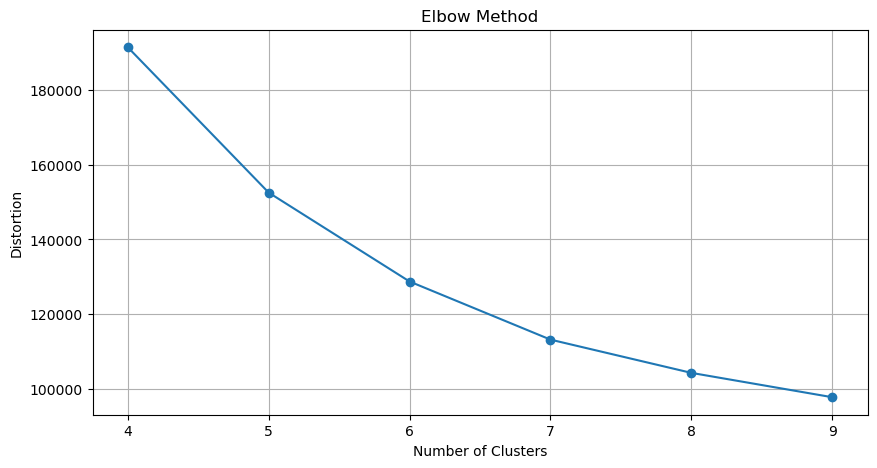

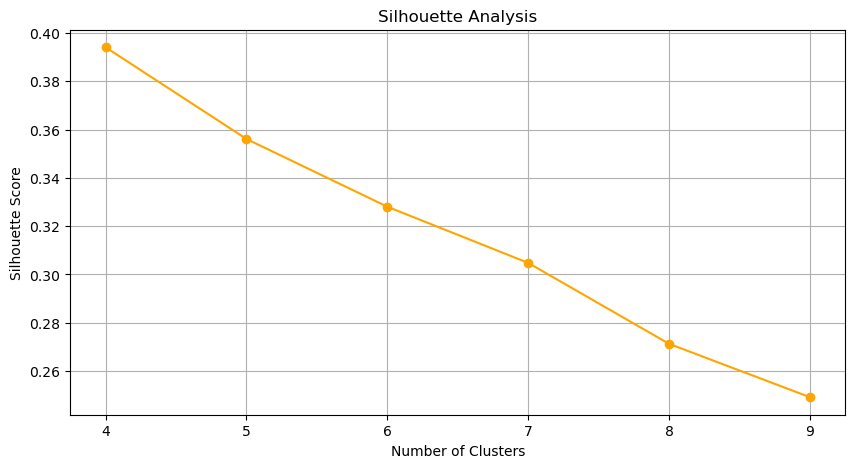

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

distortions = []
silhouette_scores = []

# Skip k=2 and k=3 since they are too small
for k in range(4, 10): 
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++')
    datacopy = data.copy()
    labels = kmeans.fit_predict(datacopy)
    
    # Calculate silhouette score
    score = silhouette_score(datacopy, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for {k} clusters: {score}")
    
    # Track distortion (inertia)
    distortions.append(kmeans.inertia_)

# Plot Distortions (Elbow Method)
plt.figure(figsize=(10, 5))
plt.plot(range(4, 10), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(4, 10), silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()


From the graphic above, we find out that the best number of clusters is 4 since we find that the silhouette score for that one is the highest among all. Now, we proceed into the clustering process.

In [55]:
# These values are achieved after some trials and errors in advanced

target_rsi_values = [30,45,55,75]
initial_centroids = np.zeros((len(target_rsi_values),18))
initial_centroids[:,6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 75.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [56]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-12-31 AAPL   -0.685759  3.809222  3.585046  3.697134         -0.000835   
           ABBV    0.724391  4.294199  4.152361  4.223280         -0.026539   
           ABT     0.301675  4.227180  4.111693  4.169437         -0.003189   
           ACN    -0.162696  5.072869  4.807611  4.940240         -0.002485   
           ADBE   -0.053444  5.576047  5.329066  5.452557          0.000161   
...                     ...       ...       ...       ...               ...   
2024-12-31 VZ     -0.411140  3.825148  3.730243  3.777695          0.000083   
           WDAY    1.768621  5.642151  5.521243  5.581697          0.000195   
           WFC     1.631313  4.365255  4.277448  4.321351          0.000135   
           WMT     2.434238  4.600110  4.427475  4.513793          0.000076   
           XOM     0.266199  4.829473  4.722610  4.776042          0.000065   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-12-31 AAPL   -1.248265  37.072896  -0.116698  -0.132708  -0.101117   
           ABBV   -0.089869  57.957305  -0.022064   0.088210  -0.004972   
           ABT    -0.323527  55.190170  -0.023228   0.024291  -0.003340   
           ACN    -1.470372  36.633865  -0.142901  -0.054156  -0.057936   
           ADBE   -0.758332  46.330419  -0.098250  -0.040535  -0.057180   
...                     ...        ...        ...        ...        ...   
2024-12-31 VZ      0.136093  46.327581  -0.053000  -0.001663  -0.017098   
           WDAY    0.911934  57.572309   0.089483   0.079203   0.036752   
           WFC     1.282341  54.066859  -0.059997   0.053210   0.084290   
           WMT     4.594018  72.966904   0.026595   0.076455   0.055519   
           XOM    -1.593250  35.123929  -0.051204  -0.021029  -0.015304   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.295926 -0.242674   
           ABBV     0.002641   0.000530   -0.000801  0.532778  0.324108   
           ABT      0.030303   0.022655    0.021488  0.760585 -0.049286   
           ACN     -0.022971  -0.007415   -0.005345  1.205504 -0.205588   
           ADBE    -0.012388   0.005118    0.021515  1.312927 -0.562123   
...                      ...        ...         ...       ...       ...   
2024-12-31 VZ       0.008325   0.005404    0.014460  0.469305 -0.482741   
           WDAY     0.033455  -0.000159   -0.001124  1.186516 -0.666855   
           WFC      0.033951   0.025934    0.033971  1.118133 -0.100227   
           WMT      0.058491   0.052742    0.051078  0.637016 -0.338806   
           XOM     -0.003356  -0.002415    0.011581  1.013520  0.061609   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.628137  0.334688  0.500211        3  
           ABBV   -0.158047  0.413359  0.537440        2  
           ABT    -0.437354  0.168987  0.980870        2  
           ACN    -0.225930  0.351370  0.013378        3  
           ADBE   -0.255000  0.315426 -0.424359        1  
...                     ...       ...       ...      ...  
2024-12-31 VZ      0.295865  0.136107  0.096883        1  
           WDAY   -0.409317 -0.912328 -0.254312        2  
           WFC     1.573137 -0.691720 -0.965336        2  
           WMT    -0.363666  0.182304  0.623447        3  
           XOM     0.894153 -0.466599  0.371946        0  

[10288 rows x 19 columns]

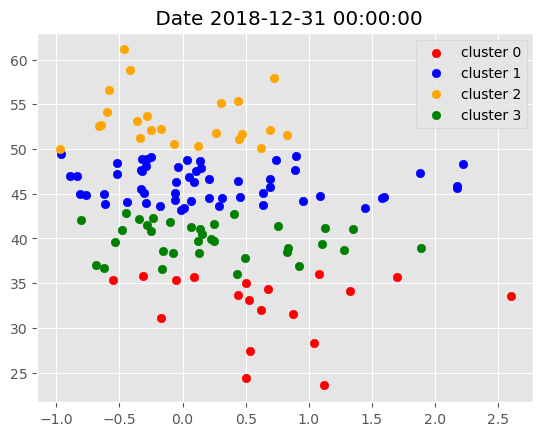

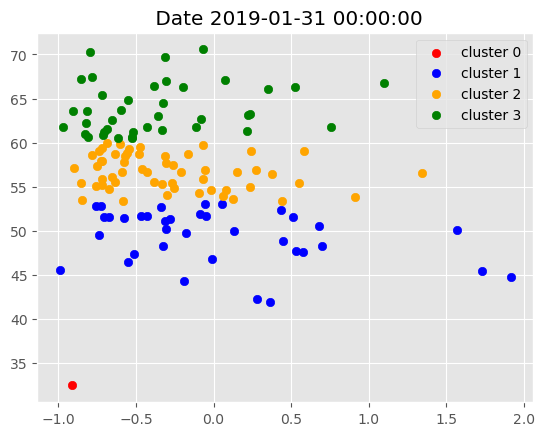

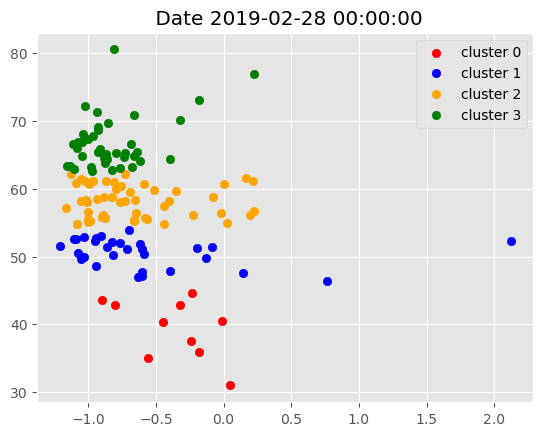

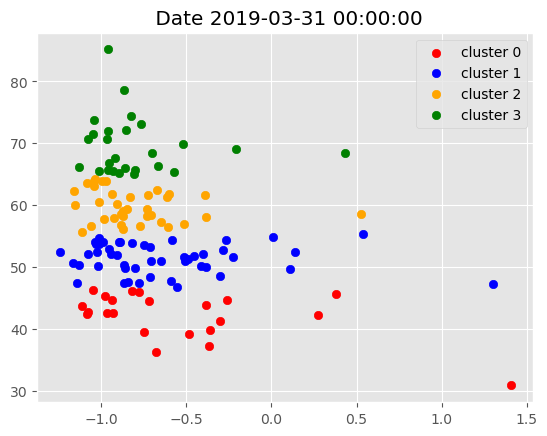

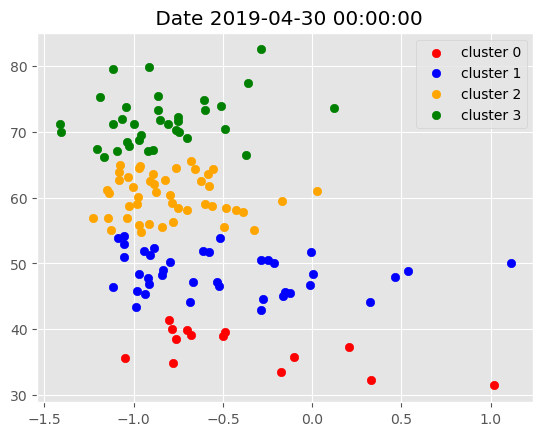

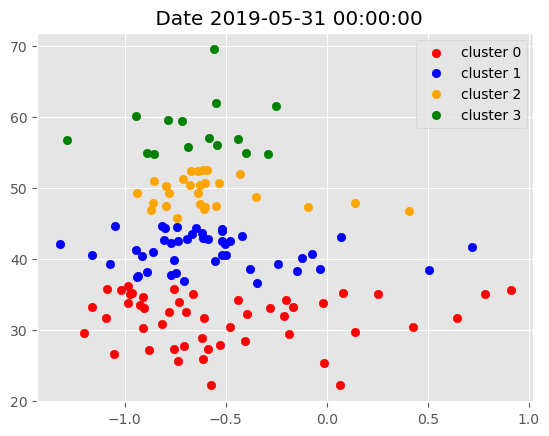

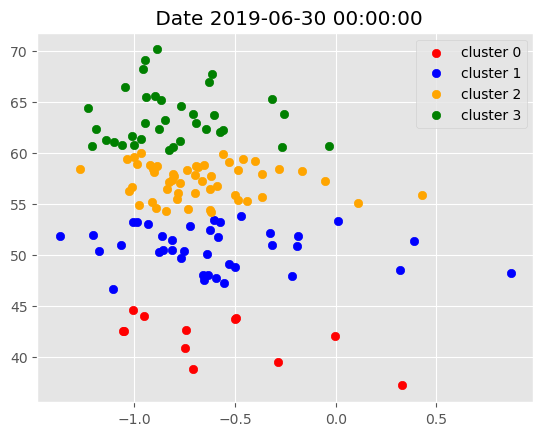

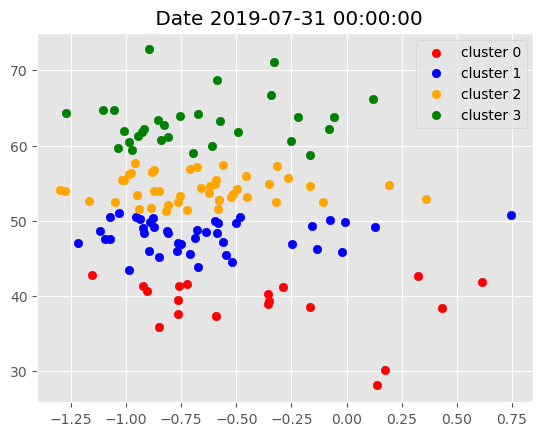

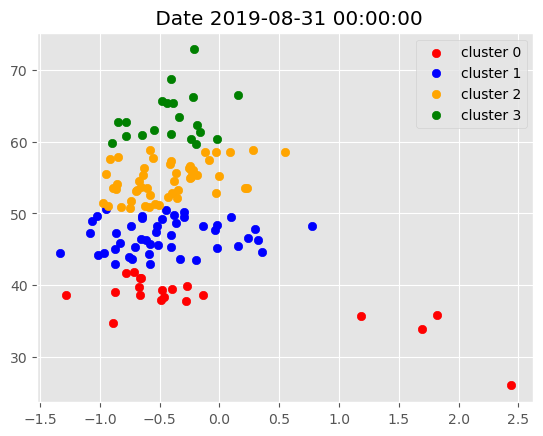

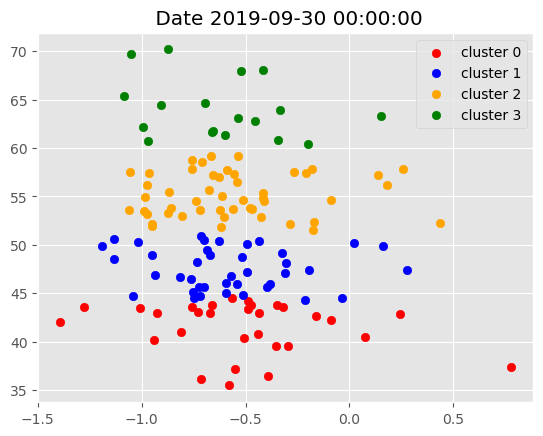

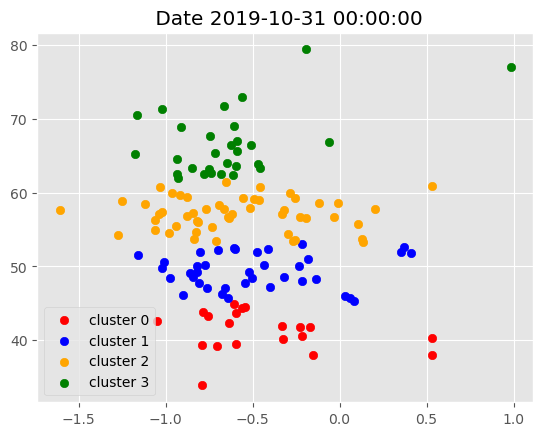

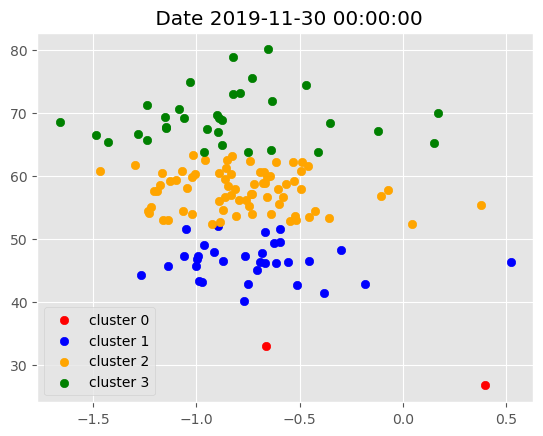

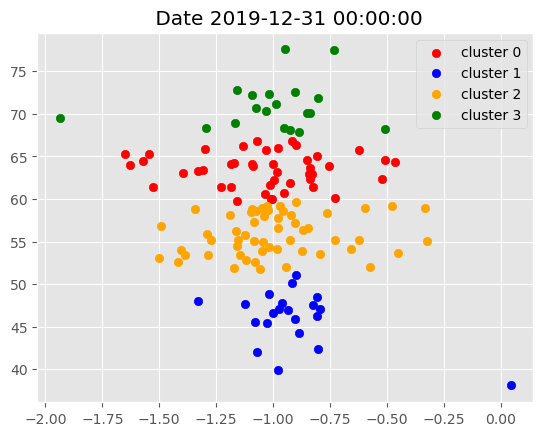

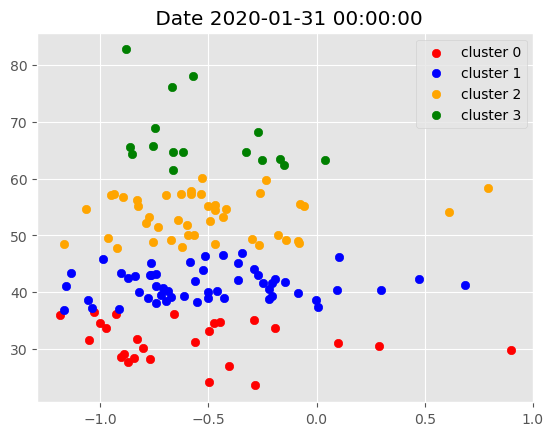

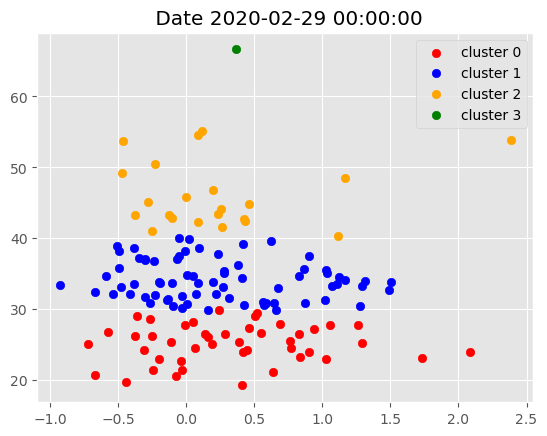

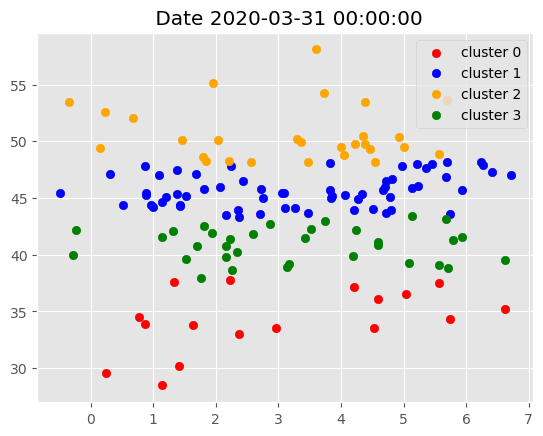

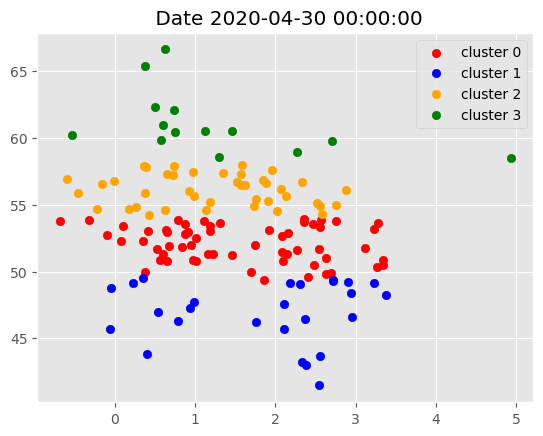

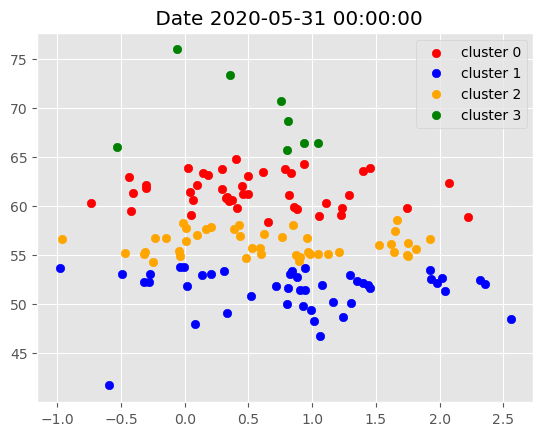

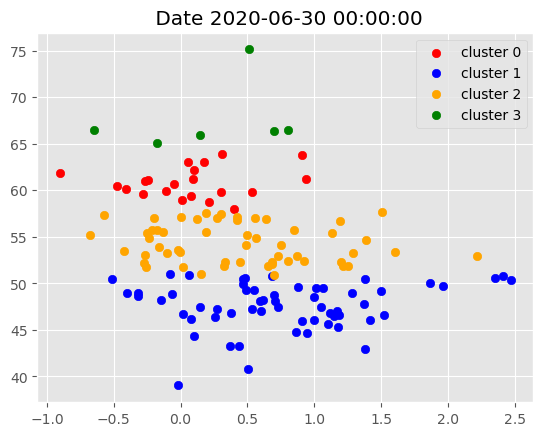

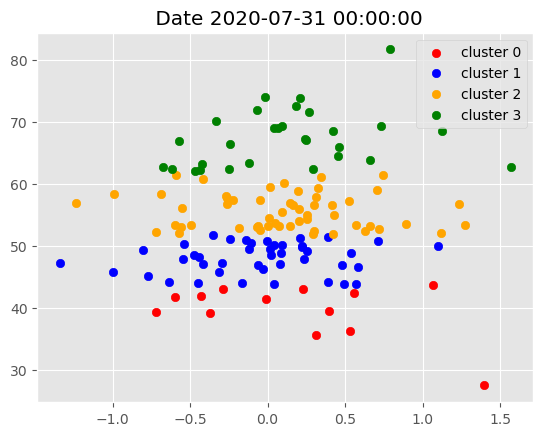

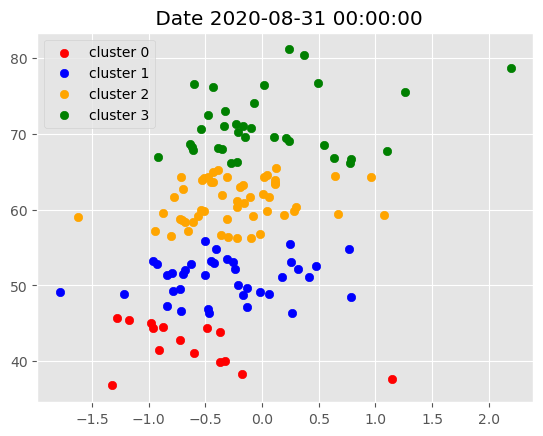

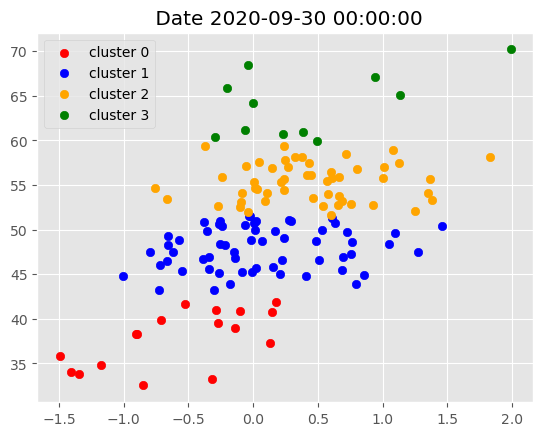

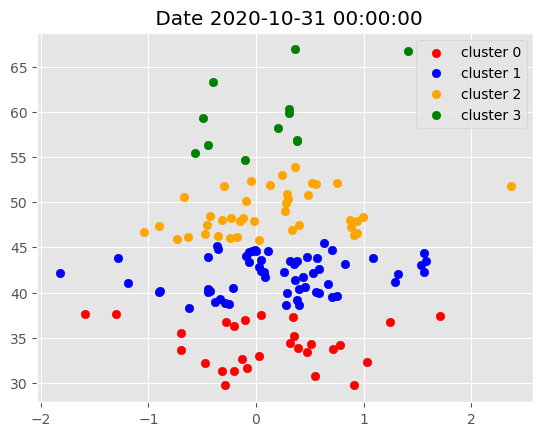

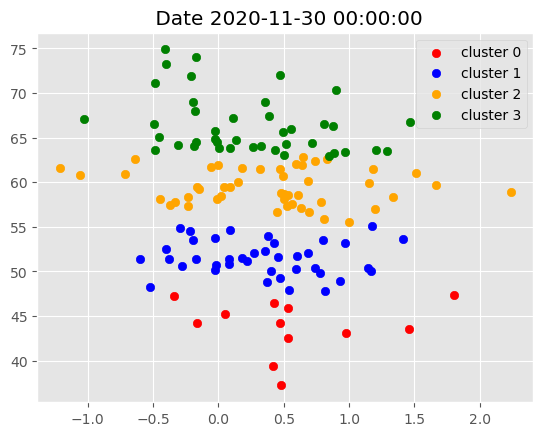

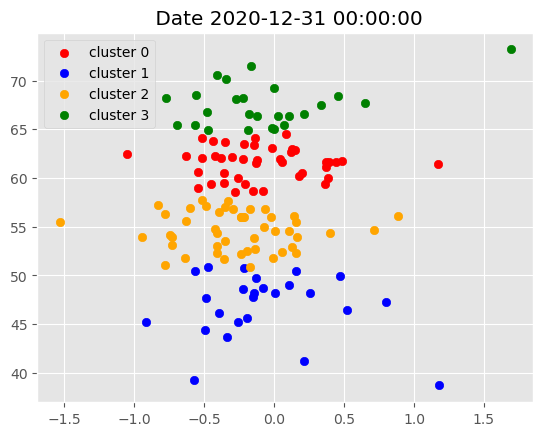

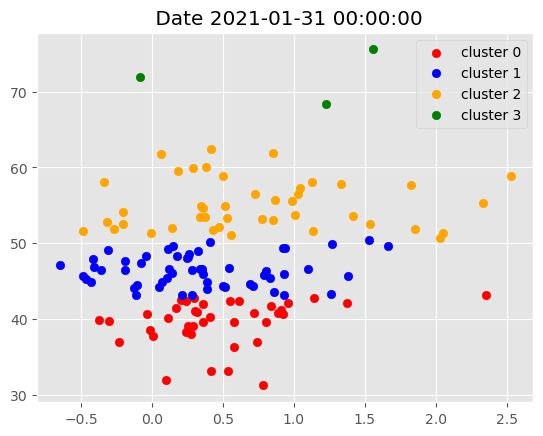

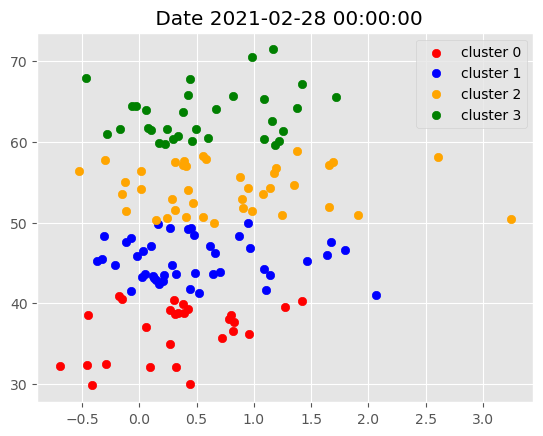

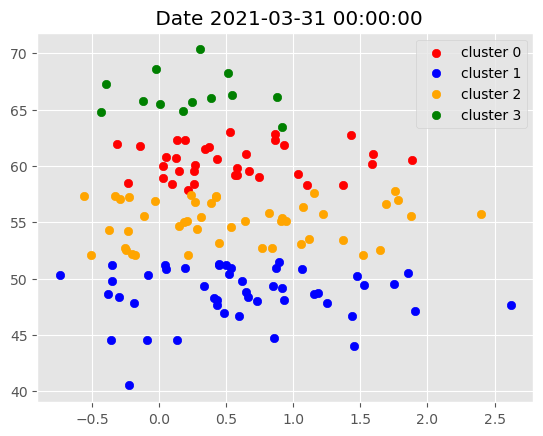

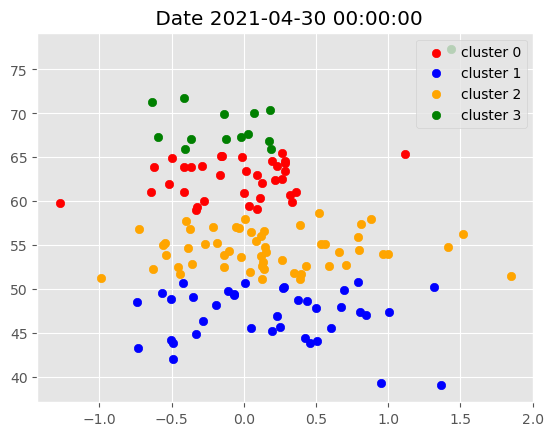

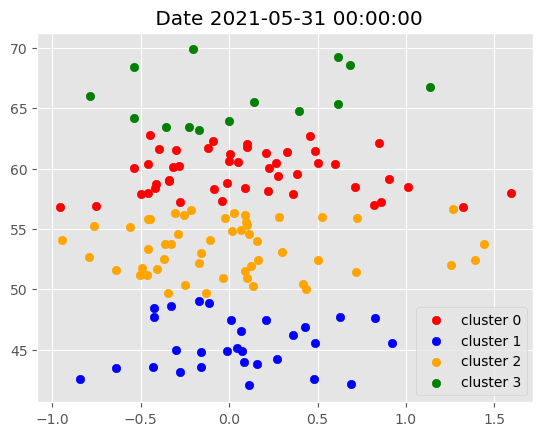

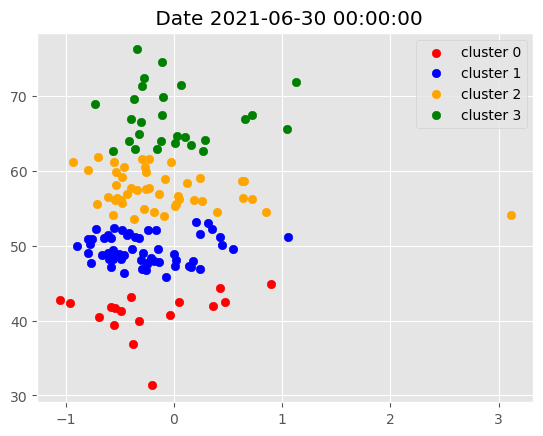

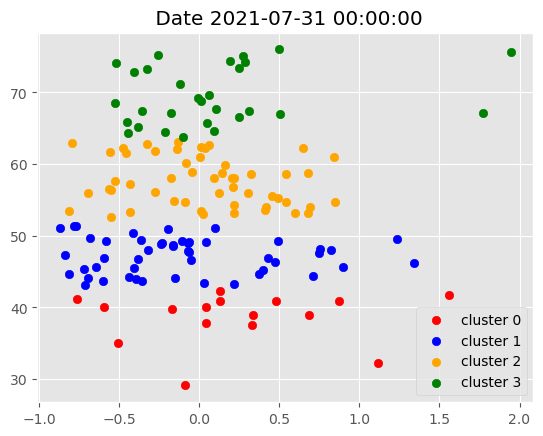

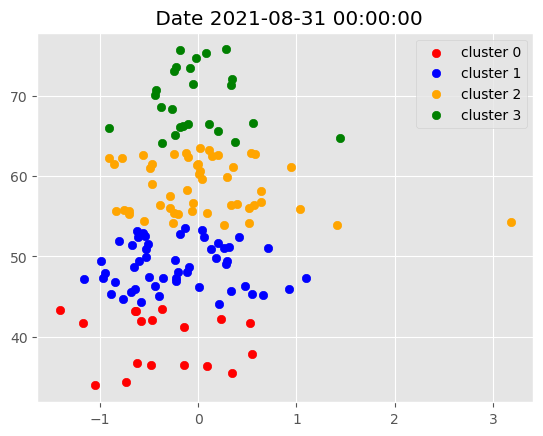

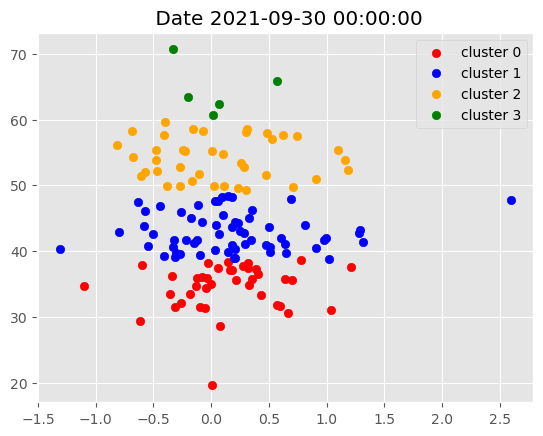

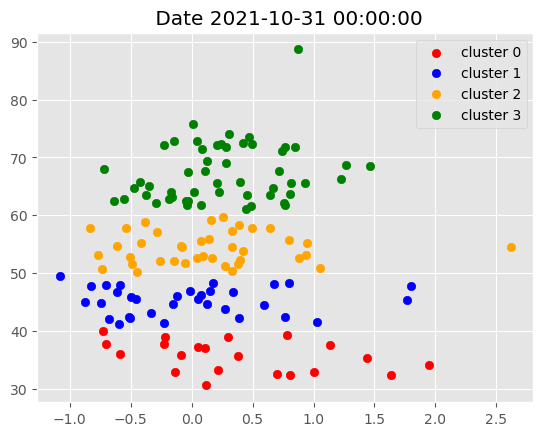

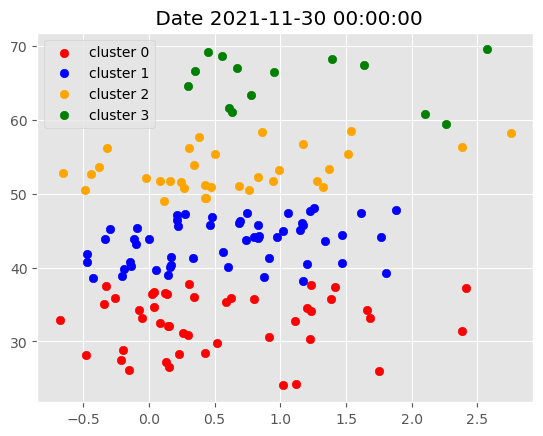

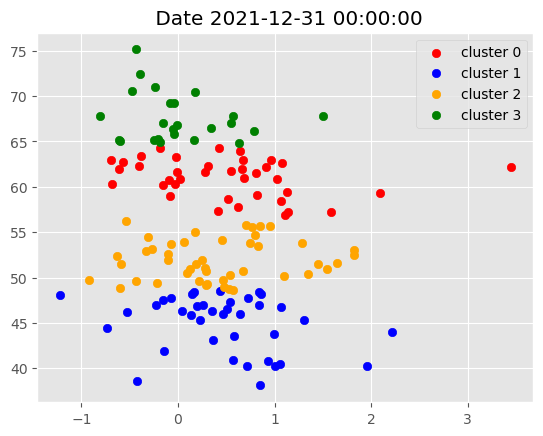

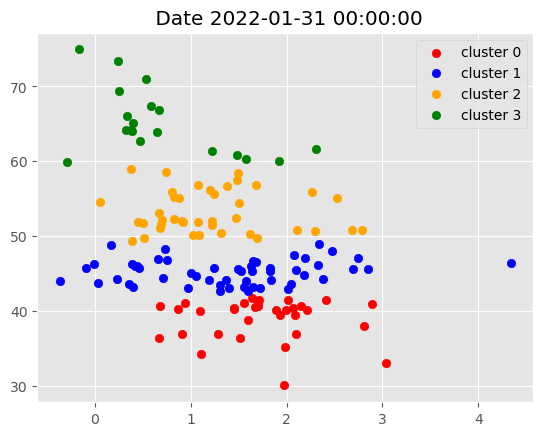

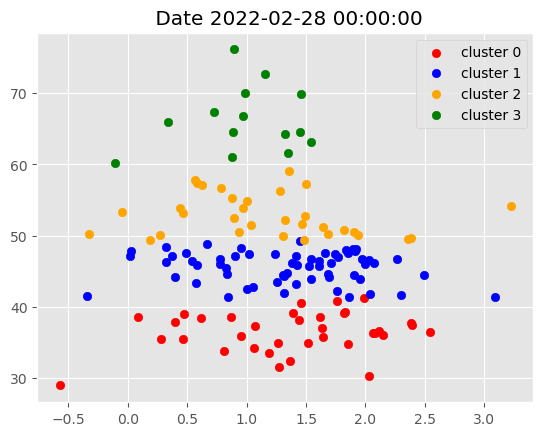

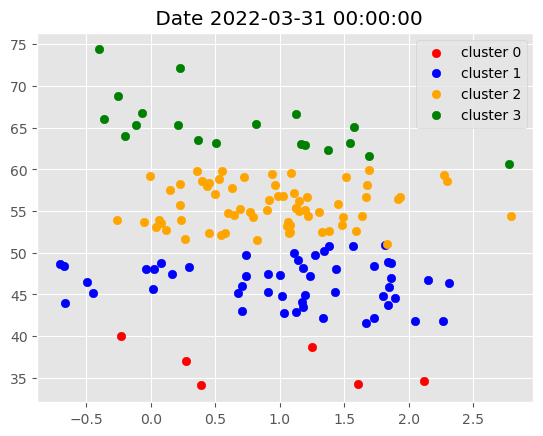

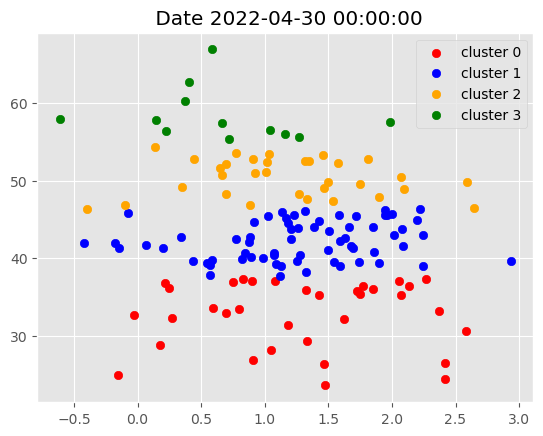

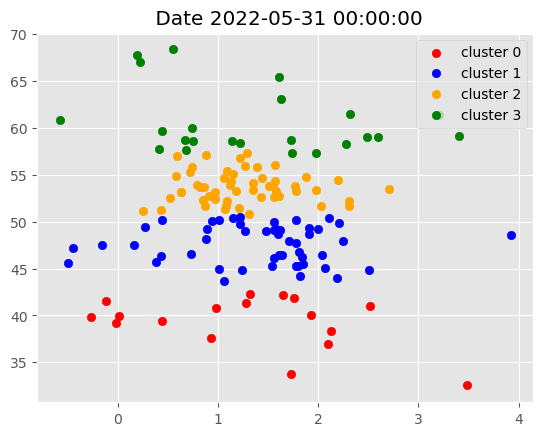

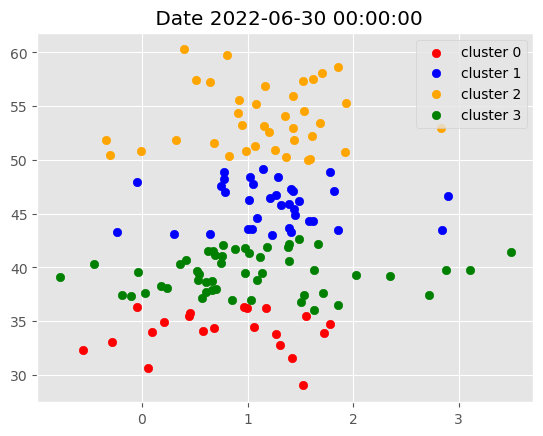

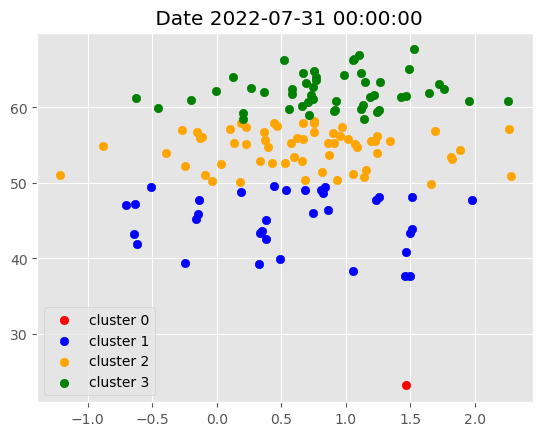

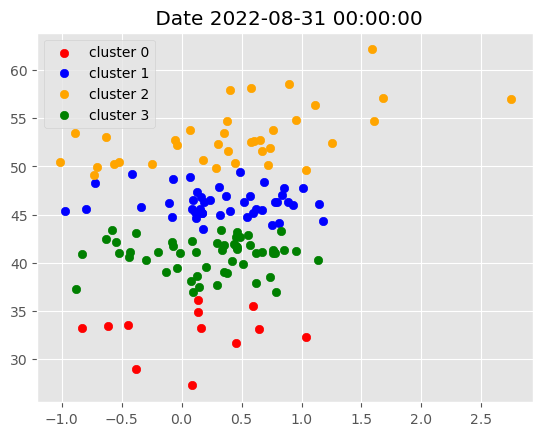

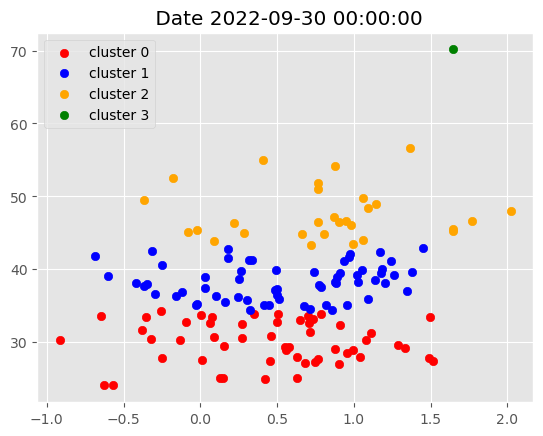

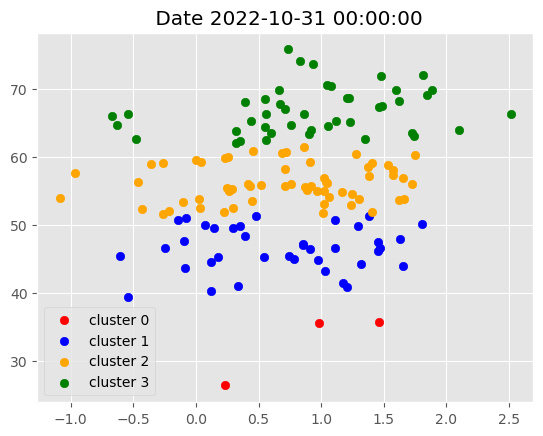

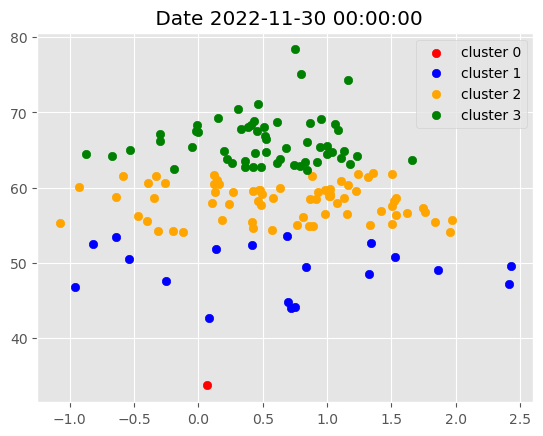

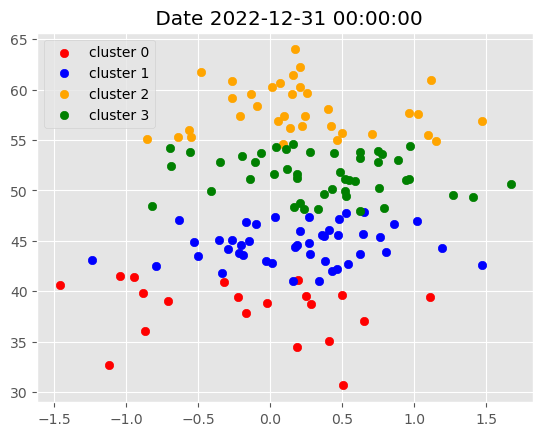

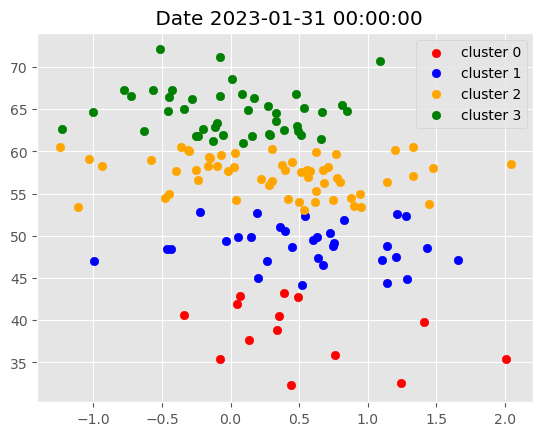

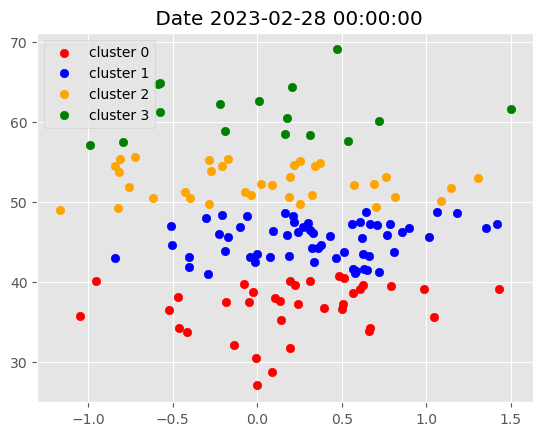

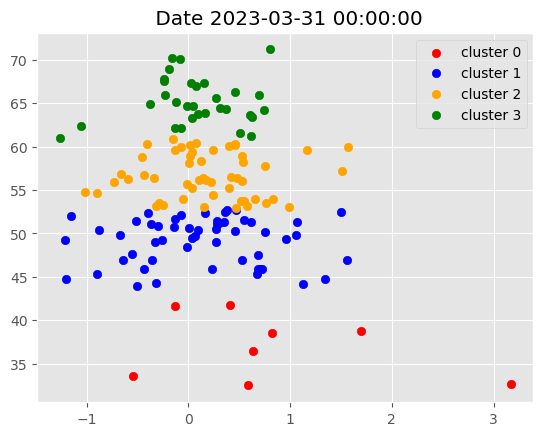

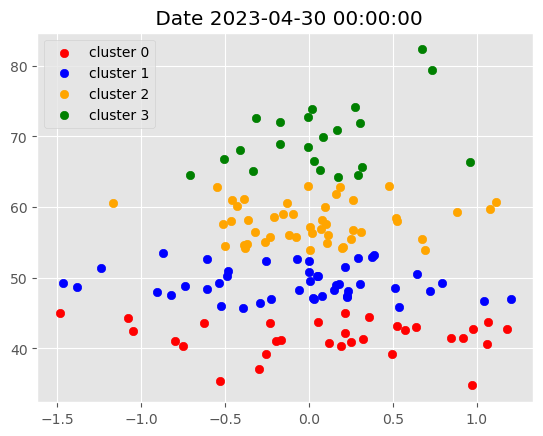

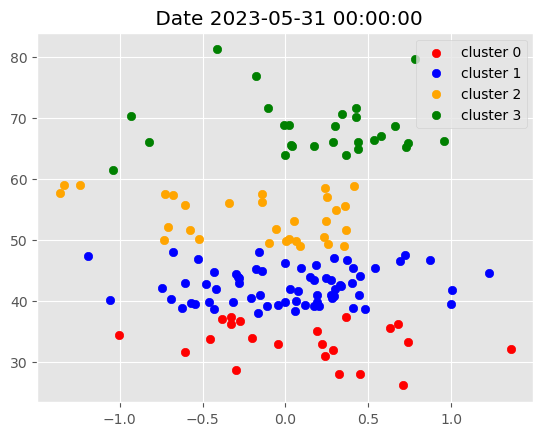

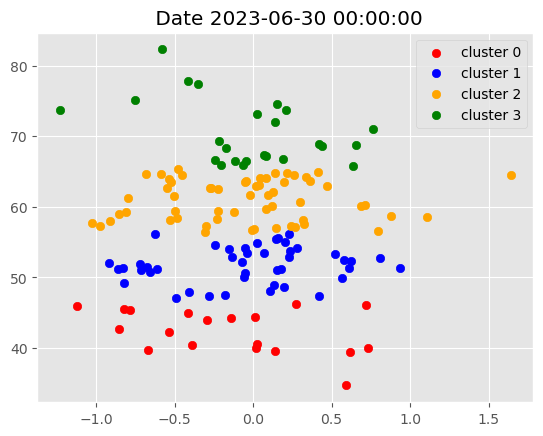

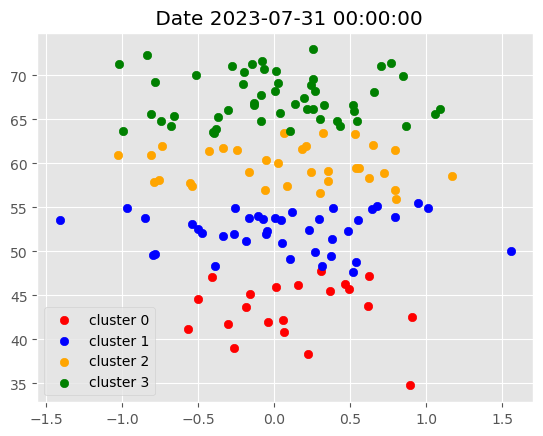

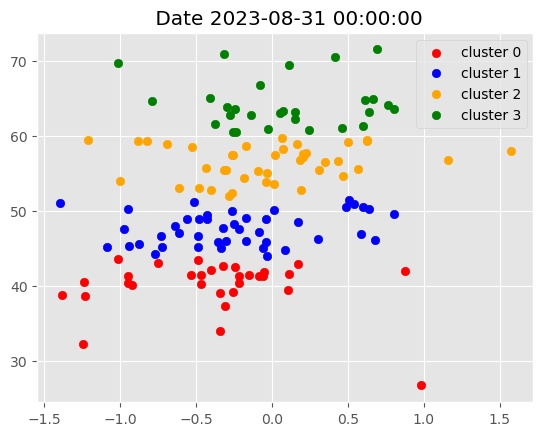

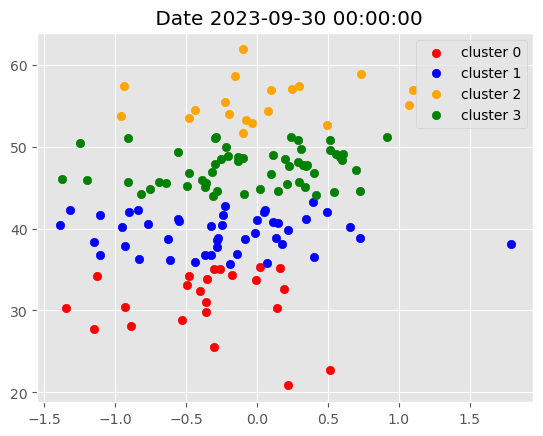

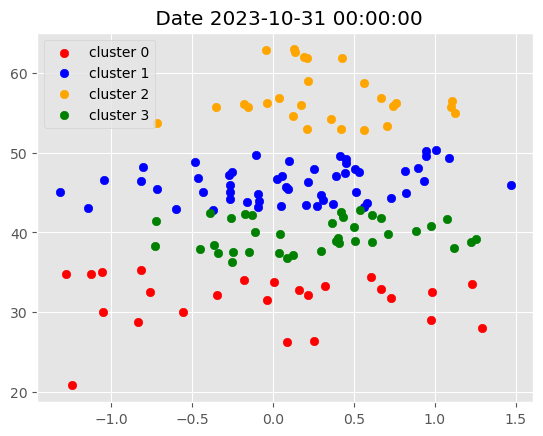

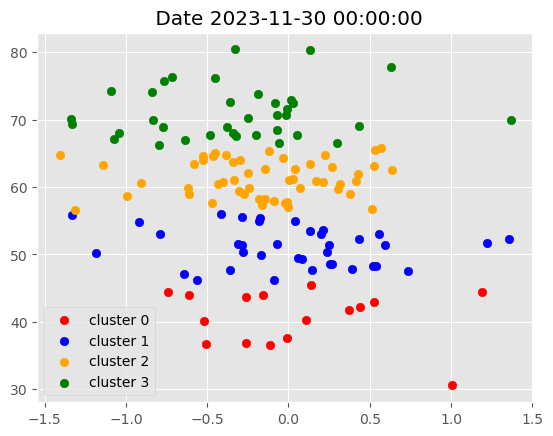

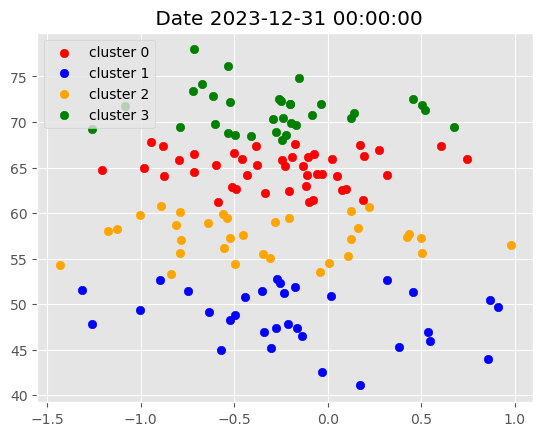

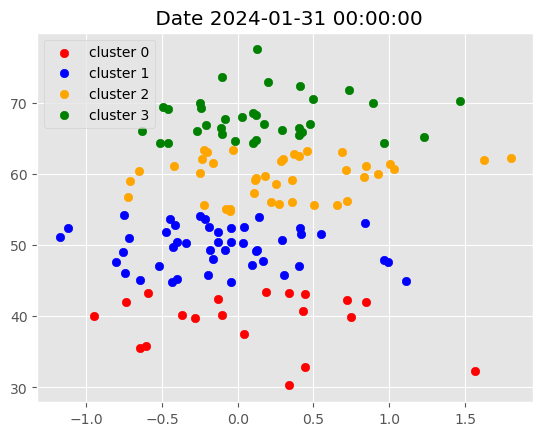

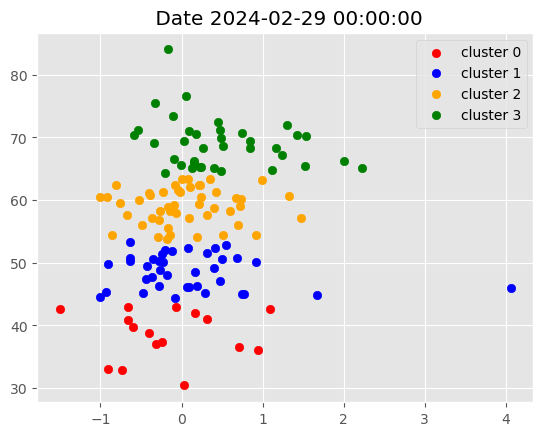

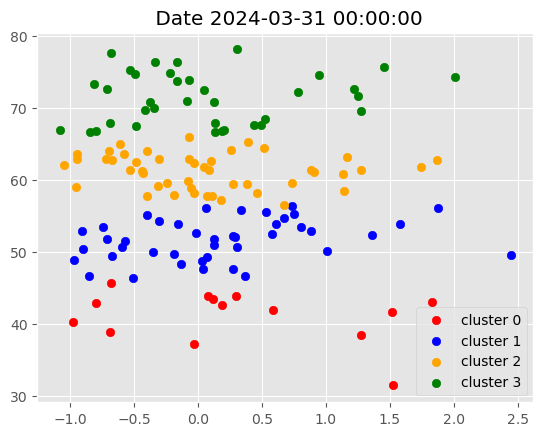

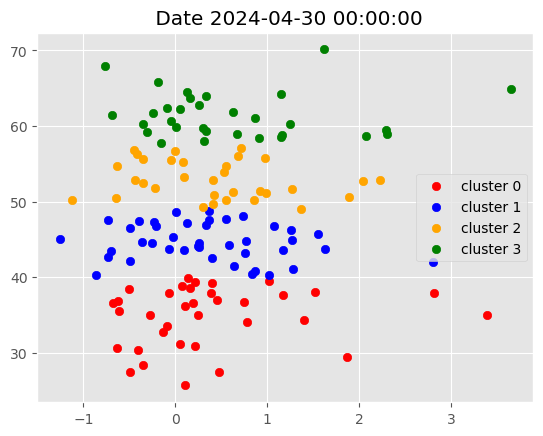

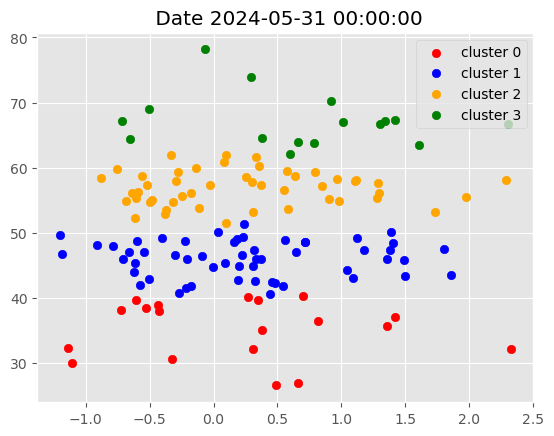

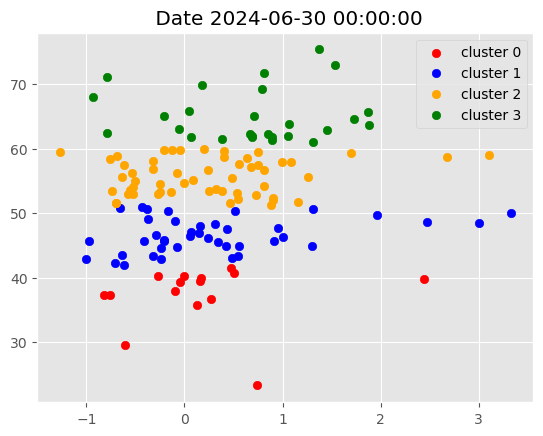

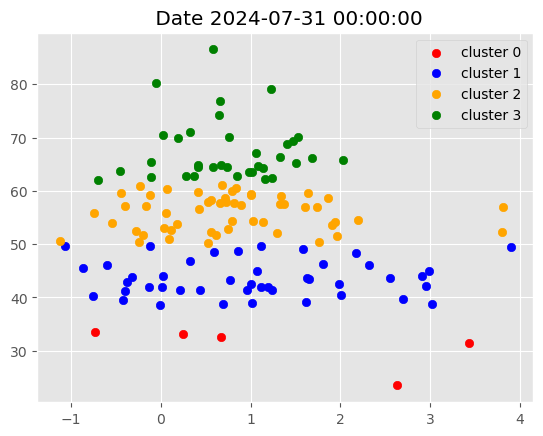

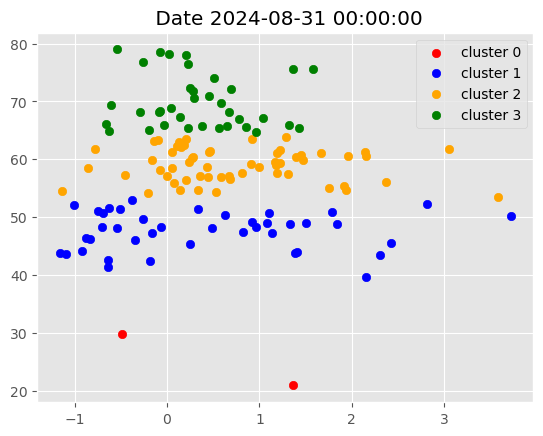

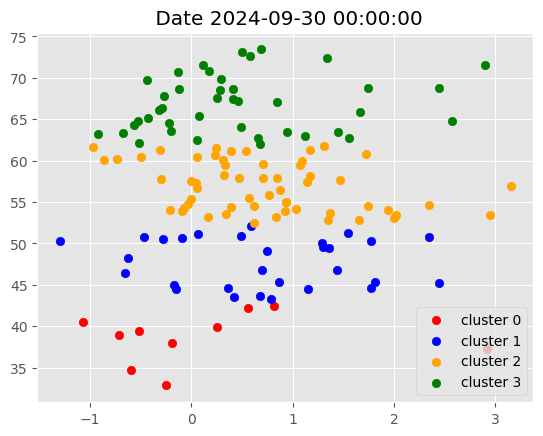

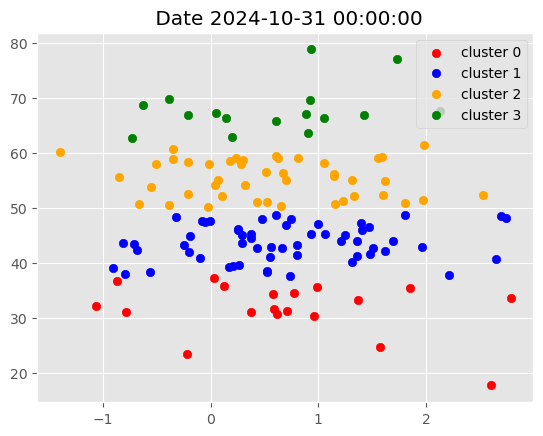

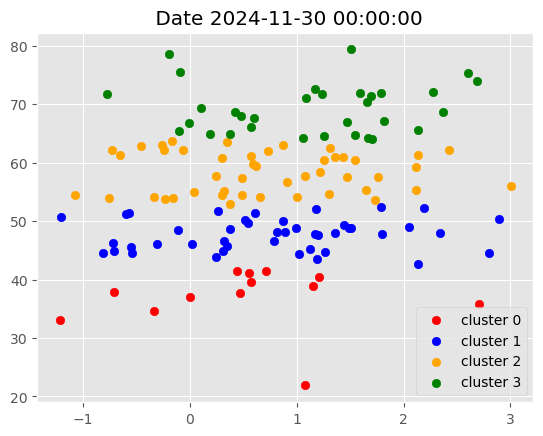

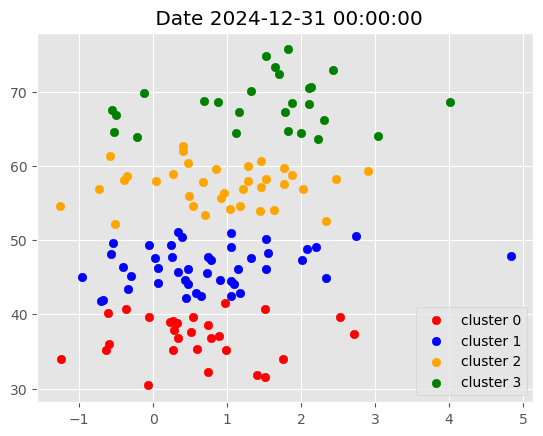

In [57]:
def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'blue', label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'orange', label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:
                ,0], cluster_3.iloc[:,6], color = 'green', label = 'cluster 3')

    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level = 0)

    plt.title(f' Date {i}')

    plot_clusters(g)

Seeing the clustering, we always find the green dots, which are clusters 3 are having a good momentum most of the time. Now, it is the time to select which stocks that we need to select in the beginning of the month according to the data that we already have.

### 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max Sharpe Ratio Optimization

In [60]:
for i in range(0, 4): 
    cluster = data[data['cluster'] == i]  
    avg_rsi = cluster['rsi'].mean()
    print(f"Average RSI for Cluster {i}: {avg_rsi}")

Average RSI for Cluster 0: 41.95079491581171
Average RSI for Cluster 1: 46.34846048402784
Average RSI for Cluster 2: 55.9957350797075
Average RSI for Cluster 3: 63.10011885442411


Cluster 3 clearly exhibits the highest average RSI, indicating strong momentum in stock prices. This suggests that stocks within this cluster are more likely to outperform others in the following month, aligning with the concept of momentum persistence. Based on this observation, we propose the following hypothesis:

1. We will focus exclusively on stocks within Cluster 3, as it has been identified and hypothetically validated as having the strongest momentum characteristics.
2. Given the persistence of momentum, we hypothesize that stocks with an RSI near 70, as represented by Cluster 3, are likely to sustain their outperformance in the subsequent month, justifying our choice of this cluster.

In [62]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2019-01-01': ['AAPL',
  'ACN',
  'ADP',
  'AXP',
  'BAC',
  'CHTR',
  'CI',
  'CMCSA',
  'COST',
  'CSX',
  'DAL',
  'EA',
  'EXPE',
  'FCX',
  'GILD',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
  'JPM',
  'LMT',
  'MCK',
  'META',
  'MS',
  'MU',
  'OXY',
  'T',
  'TGT',
  'TJX',
  'TMUS',
  'ULTA',
  'UPS',
  'VLO',
  'WFC'],
 '2019-02-01': ['ADI',
  'ADSK',
  'AMAT',
  'AMD',
  'AMT',
  'AVGO',
  'BA',
  'BDX',
  'C',
  'CHTR',
  'CMG',
  'CSCO',
  'DG',
  'DHR',
  'DLTR',
  'EBAY',
  'ELV',
  'GE',
  'GM',
  'IBM',
  'LRCX',
  'LUV',
  'MA',
  'MCK',
  'MDLZ',
  'META',
  'MGM',
  'NKE',
  'NXPI',
  'ORCL',
  'PANW',
  'PG',
  'REGN',
  'SBUX',
  'SHW',
  'TJX',
  'USB',
  'VLO',
  'WYNN'],
 '2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  '

The list above represents the stocks we may purchase at the beginning of each month starting from 2019. These stocks are selected based on their performance in the preceding month, specifically those with strong RSI values or momentum. As hypothesized earlier, we expect these stocks to continue outperforming in the following month. The remaining challenge is determining the appropriate proportion to allocate to each stock at the start of the month.

### 7. Define portfolio optimization function based on the previous list

- We will create a function to optimize portfolio weights using the **PyPortfolioOpt** package with the **EfficientFrontier** optimizer, aiming to maximize the Sharpe ratio.  
- The function will require the past 1 year of stock prices as input to perform the optimization.  
- To ensure diversification, we will set constraints on individual stock weights, with a minimum of half the equal weight and a maximum of 10% of the total portfolio.  

In [243]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    # since the dataset is not that large, to handle more stable optimization we prefer to use
    # ledoit_wolf for the covariance matters.
    cov = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

    # ecos gives more flexibility than the one in the video, gives the model to be more relaxed
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, 0.1),
                           solver='ECOS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


After having these functions, now we need to extract the past 1 year fresh data from yfinance again for each shortlisted stock above.

In [246]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  154 of 154 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-01-02   40.524338   72.345772   52.048279  138.659607  177.699997   
2018-01-03   40.517288   73.477905   52.163364  139.299545  181.039993   
2018-01-04   40.705482   73.058861   52.074829  140.948975  183.220001   
2018-01-05   41.168926   74.330673   52.225338  142.111679  185.339996   
2018-01-08   41.016033   73.139748   52.074829  143.247299  185.039993   
...                ...         ...         ...         ...         ...   
2024-12-20  254.490005  175.580002  114.230003  366.369995  447.170013   
2024-12-23  255.270004  178.389999  114.309998  358.769989  446.739990   
2024-12-24  258.200012  180.000000  114.760002  361.630005  447.940002   
2024-12-26  259.019989  179.199997  115.269997  360.429993  450.160004   
2024-12-27  255.589996  178.009995  114.989998  356.179993  446.480011   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-01-02   79.129051  100.113731  107.120003  224.619995   49.034470  ...   
2018-01-03   80.110710  101.201263  109.379997  231.199997   49.903473  ...   
2018-01-04   80.023071  102.167946  112.070000  233.300003   50.190075  ...   
2018-01-05   80.347351  102.107544  110.839996  241.070007   50.476662  ...   
2018-01-08   80.487579  101.796806  111.419998  248.899994   51.696972  ...   
...                ...         ...         ...         ...         ...  ...   
2024-12-20  211.779999  294.019989  298.119995  211.059998  163.589996  ...   
2024-12-23  214.889999  294.149994  297.489990  207.570007  167.460007  ...   
2024-12-24  218.089996  296.459991  301.230011  213.500000  168.369995  ...   
2024-12-26  218.059998  297.230011  300.279999  215.500000  167.550003  ...   
2024-12-27  216.990005  296.179993  297.589996  211.429993  166.830002  ...   

Price        Volume                                                   \
Ticker          VLO     VRTX        VZ       WBA      WDAY       WDC   
Date                                                                   
2018-01-02  3582900  1382000  16045300   6605000   1599600   3894000   
2018-01-03  3057600  1604000  16662400   7147300   2047900   3253300   
2018-01-04  2977000  1345100  12062800  12456000   2774000   5173100   
2018-01-05  2973800  1940000  13348900   9067200   1025400   2727400   
2018-01-08  2493400  1987000  16212700   5312500   1626600   4875300   
...             ...      ...       ...       ...       ...       ...   
2024-12-20  7606100  6203100  47590900  29994300  46874100  12732400   
2024-12-23  2832600  2204300  21292300  18506100   3676000   4111200   
2024-12-24  1170100  1468600  11712200   8724500    850500   1512100   
2024-12-26  1884400  1191500  12953100  15746500   1243900   2146000   
2024-12-27  1697800  1373400  15142000  11610000   1602800   4161800   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2018-01-02  13819300  30451500  2581200  11469300  
2018-01-03  14203700  26710800  3530900  13957700  
2018-01-04  18740500  20491200  2708800  10863000  
2018-01-05  14217900  21852000  2186600  11047600  
2018-01-08  15569400  26531700  1803800  10927100  
...              ...       ...      ...       ...  
2024-12-20  50113400  49350600  2663400  40141200  
2024-12-23  11817000  26205400  1312400  12285100  
2024-12-24   4442700   8992400   692800   7807000  
2024-12-26   6964300  10997600  1218900   9653400  
2024-12-27   7219500  11376900  1086700  11933000  

[1759 rows x 924 columns]

- We start with calculating the daily returns of each stock that could land in our portfolio
- Then loop over each month's start, select the stocks for the month, and calculate their weights for the next month.
- If the maximum Sharpe ratio optimization fails for a given month, apply equally-weighted weights
- Calculated each day's portfolio return

In [248]:
fixed_dates

{'2019-01-01': ['AAPL',
  'ACN',
  'ADP',
  'AXP',
  'BAC',
  'CHTR',
  'CI',
  'CMCSA',
  'COST',
  'CSX',
  'DAL',
  'EA',
  'EXPE',
  'FCX',
  'GILD',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
  'JPM',
  'LMT',
  'MCK',
  'META',
  'MS',
  'MU',
  'OXY',
  'T',
  'TGT',
  'TJX',
  'TMUS',
  'ULTA',
  'UPS',
  'VLO',
  'WFC'],
 '2019-02-01': ['ADI',
  'ADSK',
  'AMAT',
  'AMD',
  'AMT',
  'AVGO',
  'BA',
  'BDX',
  'C',
  'CHTR',
  'CMG',
  'CSCO',
  'DG',
  'DHR',
  'DLTR',
  'EBAY',
  'ELV',
  'GE',
  'GM',
  'IBM',
  'LRCX',
  'LUV',
  'MA',
  'MCK',
  'MDLZ',
  'META',
  'MGM',
  'NKE',
  'NXPI',
  'ORCL',
  'PANW',
  'PG',
  'REGN',
  'SBUX',
  'SHW',
  'TJX',
  'USB',
  'VLO',
  'WYNN'],
 '2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  '

In [249]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        optimization_df = optimization_df.dropna(how= 'any', axis = 1)
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2019-01-02,0.002955
2019-01-03,-0.022667
2019-01-04,0.034479
2019-01-07,0.010063
2019-01-08,0.008096
...,...
2024-12-20,0.012296
2024-12-23,-0.000729
2024-12-24,0.014430


<Axes: xlabel='date'>

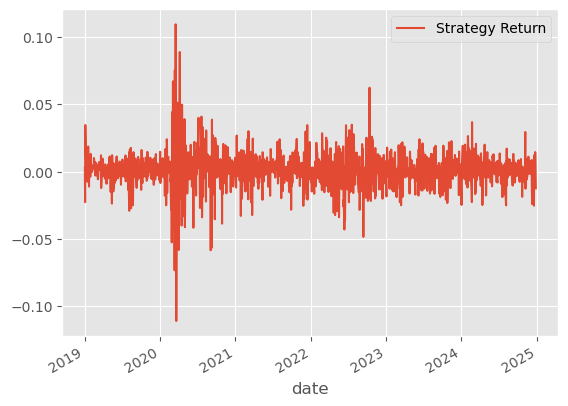

In [250]:
portfolio_df.plot()

### 8. Visualize Portfolio returns and compare to SP500 returns

In [252]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2019-01-02,0.002955,0.001040
2019-01-03,-0.022667,-0.024152
2019-01-04,0.034479,0.032947
2019-01-07,0.010063,0.007853
2019-01-08,0.008096,0.009352
...,...,...
2024-12-20,0.012296,0.011939
2024-12-23,-0.000729,0.005970
2024-12-24,0.014430,0.011054
2024-12-26,0.000479,0.000067


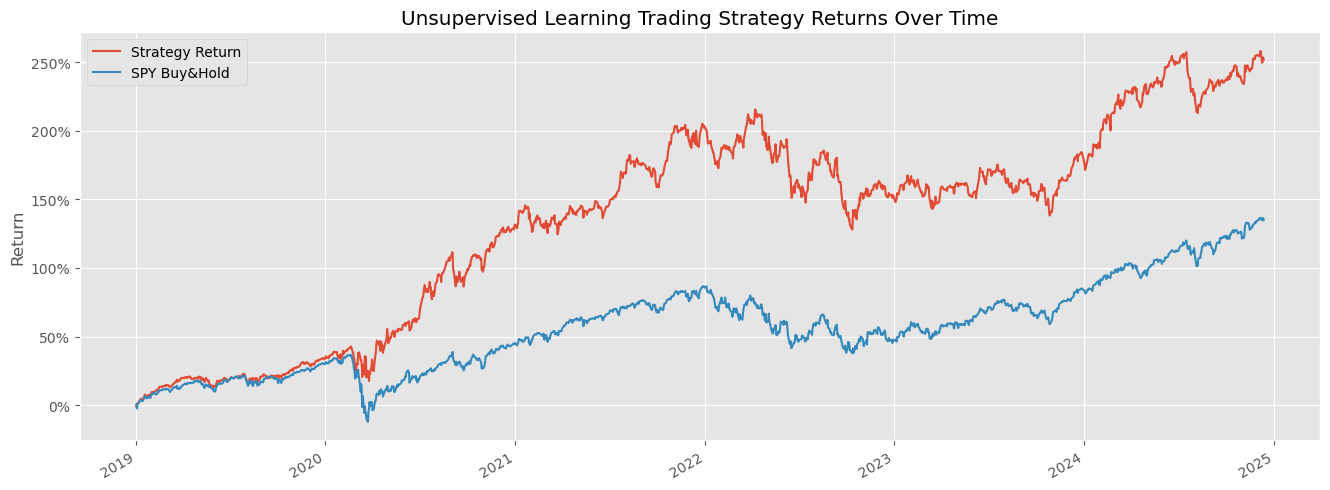

In [260]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-12-12'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


In [272]:
portfolio_cumulative_return['comparison'] = portfolio_cumulative_return['Strategy Return']/portfolio_cumulative_return['SPY Buy&Hold']
portfolio_cumulative_return

,Strategy Return,SPY Buy&Hold,comparison
2019-01-02,0.002955,0.001040,2.841946
2019-01-03,-0.019779,-0.023137,0.854851
2019-01-04,0.014018,0.009047,1.549415
2019-01-07,0.024223,0.016972,1.427219
2019-01-08,0.032515,0.026482,1.227797
...,...,...,...
2024-12-20,2.457882,1.306563,1.881182
2024-12-23,2.455363,1.320334,1.859653
2024-12-24,2.505225,1.345982,1.861262
2024-12-26,2.506903,1.346138,1.862292


In [276]:
portfolio_cumulative_return['comparison'].max()

35.91413730072115

Using the strategy we have developed, our approach has the potential to achieve returns two to three times greater than the traditional S&P 500 buy-and-hold strategy. While there may be occasional months with lower returns, the cumulative performance over the years demonstrates significant gains. By the end of 2024, this strategy could deliver over 100% total return. This concludes the analysis in this notebook. If you have any questions or queries, feel free to reach out via the email provided in the previous notebook.